In [1]:
import numpy as np
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'xtick.direction':'in',
         'ytick.direction':'in',
         }
plt.rcParams.update(params)

# 偏微分方程式

偏微分方程式は、たとえば**場**などの複数変数の関数を扱うときに出てくる。

例としては：

- 静電ポテンシャル $\phi (x,y,z)$ (Poisson's equation)
$$
\Delta\phi(x,y,z) = -\frac{\rho(x,y,z)}{\epsilon_0}
$$

- 密度/温度分布 (拡散/熱伝導 equation)
$$
\frac{\partial u(\mathbf{x},t)}{\partial t} = D \Delta u(\mathbf{x},t)
$$

- 変位 (振幅) 分布 (波動方程式)
$$
\frac{\partial^2 u(\mathbf{x},t)}{\partial t^2} = c^2\Delta u(\mathbf{x},t)
$$

- 流体方程式 (流速) -- e.g. Navier-Stokes 方程式
$$
\frac{\partial \boldsymbol{u}}{\partial t} + (\boldsymbol{u} \cdot \boldsymbol{\nabla}) \boldsymbol{u} = - \frac1{\rho} \boldsymbol{\nabla} p + \nu \nabla^2 \boldsymbol{u} + \boldsymbol{g}
$$

### 偏微分方程式の一般的解法

- **有限差分法**
    - 微分を有限差分で近似
    - 他の方法より簡単に実装可能
    - 通常の形状（長方形など）に最適
- 有限密度法
    - システムを小さな部分に分割する
    - 2次元/3次元の境界値問題
    - 不規則な形状にも有効
- 有限体積法
    - 各メッシュポイントの周囲の面積分を体積積分に変換
    - 設計上、質量が保存されるため、流体方程式に適する

# 境界値問題

<img src="http://www-personal.umich.edu/~mejn/cp/figures/fig9-2.png" alt="Electrostatics problem" style="width: 400px;"/> 
<center>
    Source: M. Newman, Computational Physics
</center>

境界値問題は通常、静的解（時間変数なし）を扱う。

2次元におけるラプラス方程式（外部電荷なし）を考えよう。
$$
\frac{\partial^2 \phi(x,y)}{\partial x^2}
+
\frac{\partial^2 \phi(x,y)}{\partial y^2}
=
0.
$$



境界条件: 壁の1つに電圧$V$が印加され、残りの壁は接地される。
\begin{align*}
\phi(x,L) & = V, \\
\phi(x,0) & = 0, \\
\phi(0,y) & = 0, \\
\phi(L,y) & = 0.
\end{align*}

差分法を適用しよう。
ボックスを各方向にステップ$a = L / M$でグリッドに離散化する。
微分を中心差分で近似する。
\begin{align*}
\frac{\partial^2 \phi(x,y)}{\partial x^2} & = \frac{\phi(x+a,y) - 2\phi(x,y) + \phi(x-a,y)}{a^2}, \\
\frac{\partial^2 \phi(x,y)}{\partial y^2} & = \frac{\phi(x,y+a) - 2\phi(x,y) + \phi(x,y-a)}{a^2}.
\end{align*}

このときラプラス方程式は
$$
\phi(x+a,y) + \phi(x-a,y) + \phi(x,y+a) + \phi(x,y-a) - 4 \phi(x,y) = 0.
$$

原理的には、これは正確に解ける$N \sim M^2$個の線形連立方程式である。
しかしながら、一般的な方法では$O(N^3) = O(M^6)$回の演算が必要となり、$M \sim 100$程度では既に実行不可能となる。

## Jacobi 法 (緩和法)

初期推定値$\phi_0(x,y)$から始める。箱内の全ての点$(x,y)$について次の反復は次のように与えられる。
$$
\phi_{n+1}(x,y) = \frac{\phi_n(x+a,y) + \phi_n(x-a,y) + \phi_n(x,y+a) + \phi_n(x,y-a)}{4}
$$
各反復において境界条件は保存される：
\begin{align*}
\phi_{n+1}(x,L) & = V, \\
\phi_{n+1}(x,0) & = 0, \\
\phi_{n+1}(0,y) & = 0, \\
\phi_{n+1}(L,y) & = 0.
\end{align*}

これはヤコビ法（または緩和法）であり、ラプラス方程式では常に収束することが知られる。

In [2]:
# Jacobi法の繰り返しの1ステップ。
# 新しい場の変数は phinew に上書きされる。
def iteration_jacobi(phinew, phi):
    M = len(phi) - 1
    
    # Boundary conditions
    phinew[0,:] = phi[0,:]
    phinew[M,:] = phi[M,:]
    phinew[:,0] = phi[:,0]
    phinew[:,M] = phi[:,M]
    
    for i in range(1,M):
        for j in range(1,M):
            phinew[i,j] = (phi[i+1,j] + phi[i-1,j] + phi[i,j+1] + phi[i,j-1])/4
                
    delta = np.max(abs(phi-phinew))
    
    return delta

def jacobi_solve(phi0, target_accuracy = 1e-6, max_iterations = 100):
    delta = target_accuracy + 1.
    phi = phi0.copy()
    for i in range(max_iterations):
        delta = iteration_jacobi(phi, phi0)
        phi0, phi = phi, phi0
        
        if (delta <= target_accuracy):
            print("Jacobi method converged in " + str(i+1) + " iterations")
            return phi0
        
    print("Jacobi method failed to converge to a required precision in " + str(max_iterations) + " iterations")
    print("The error estimate is ", delta)
        
    return phi

Jacobi method converged in 1909 iterations


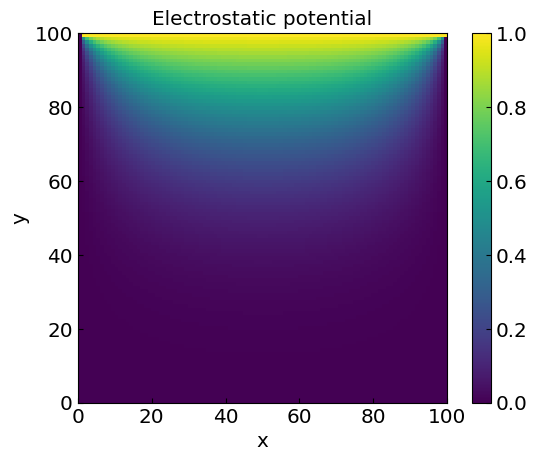

CPU times: user 14.4 s, sys: 202 ms, total: 14.6 s
Wall time: 15.4 s


In [3]:
%%time

# 定数
M = 100         # 1辺のグリッドの数
V = 1.0         # 上端の壁の電圧 [V]
target = 1e-4   # 目標の精度

# 場の変数をゼロで初期化
phi = np.zeros([M+1,M+1],float)
# 境界条件
phi[0,:] = V
phi[:,0] = 0

phi = jacobi_solve(phi, target, 10000)

# プロット
import matplotlib.pyplot as plt

plt.title("Electrostatic potential")
plt.xlabel("x")
plt.ylabel("y")
CS = plt.imshow(phi, vmax=1., vmin=0.,origin="upper",extent=[0,M,0,M])
plt.colorbar(CS)
plt.show()

## Gauss-Seidel 法、SOR 法

基本のヤコビ法の1ステップは
$$
\phi_{n+1}(x,y) = \frac{\phi_n(x+a,y) + \phi_n(x-a,y) + \phi_n(x,y+a) + \phi_n(x,y-a)}{4}
$$

これには2つの配列が独立して必要になる。
ガウス・ザイデル法では、利用可能な場合は既に計算済みの$\phi_{n+1}$の値を使用する。
この方法は次の式に対応：
$$
\phi_{n+1}(x,y) = \frac{\phi_n(x+a,y) + \phi_{n+1}(x-a,y) + \phi_n(x,y+a) + \phi_{n+1}(x,y-a)}{4}
$$

もう一つの修正は、加速緩和 (overrelaxation) を使うことである。

基本のヤコビ法の1ステップは
$$
\phi_{n+1}(x,y) = \phi_n(x,y) + \Delta_n \phi(x,y).
$$

計算を加速するには、解を加速緩和 (overrelaxation) する：
$$
\phi_{n+1}(x,y) = \phi_n(x,y) + (1+\omega) \Delta_n \phi(x,y),
$$
ここで $\omega > 0$.

これをヤコビ法に適用すると以下のようになる。
$$
\phi_{n+1}(x,y) = (1+\omega) \frac{\phi_n(x+a,y) + \phi_n(x-a,y) + \phi_n(x,y+a) + \phi_n(x,y-a)}{4} - \omega \, \phi_n(x,y).
$$
しかし、これは $\omega > 0$。

一方で、Gauss-Seidel 法に適用したときには、以下のようになる。
$$
\phi_{n+1}(x,y) = (1+\omega) \frac{\phi_n(x+a,y) + \phi_{n+1}(x-a,y) + \phi_n(x,y+a) + \phi_{n+1}(x,y-a)}{4} - \omega \, \phi_n(x,y),
$$
これは $\omega < 1$ で安定解を導く。

In [4]:
# ヤコビ法の1ステップ
# 新しい場の変数は phinew に上書きされる。
# omega >= 0 は 加速緩和パラメタ
def sor_iteration(phi, omega = 0):
    M = len(phi) - 1
    
    delta = 0.
    
    # 加速緩和
    for i in range(1,M):
        for j in range(1,M):
            phiold = phi[i,j]
            phi[i,j] = (1. + omega) * (phi[i+1,j] + phi[i-1,j] + phi[i,j+1] + phi[i,j-1])/4 - omega * phi[i,j]
            delta = np.maximum(delta, abs(phiold - phi[i,j]))
    
    return delta

def sor_solve(phi0, omega = 0, target_accuracy = 1e-6, max_iterations = 100):
    delta = target_accuracy + 1.
    phi = phi0.copy()
    for i in range(max_iterations):
        delta = sor_iteration(phi, omega)
        
        if (delta <= target_accuracy):
            print("SOR method converged in " + str(i+1) + " iterations")
            return phi
        
    print("SOR method failed to converge to a required precision in " + str(max_iterations) + " iterations")
    print("The error estimate is ", delta)
        
    return phi

SOR method converged in 202 iterations


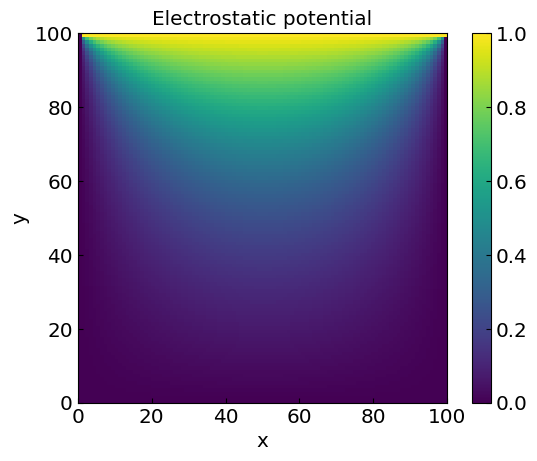

CPU times: user 5.78 s, sys: 162 ms, total: 5.95 s
Wall time: 6.65 s


In [5]:
%%time

# 定数
M = 100         # 1辺のグリッドの数
V = 1.0         # 上端の壁の電圧 [V]
target = 1e-4   # 目標の精度

# ゼロで初期化：
phi = np.zeros([M+1,M+1],float)
# 境界条件
phi[0,:] = V
phi[:,0] = 0


omega = 0.9
phi = sor_solve(phi, omega, target, 1000)

# Plot
plt.title("Electrostatic potential")
plt.xlabel("x")
plt.ylabel("y")
CS = plt.imshow(phi, vmax=1., vmin=0.,origin="upper",extent=[0,M,0,M])
plt.colorbar(CS)
plt.show()

一般に、SOR 法の方が、収束が早く、必要なステップ数が少ないことが確認できるだろう。

# 初期値問題

ほとんどの場合、物理ではある分布関数 $u(t,\mathbf{x})$ の時間発展に興味がある。
この場合、偏微分方程式は、いくつかの初期条件から始まり境界条件に従う、場の時間発展を記述する。

例として熱方程式を取り上げる。
場 $u$ は温度 $T$ である。
1次元の場合、熱方程式は次のように表される。
$$
\frac{\partial u}{\partial t} = D \, \frac{\partial^2 u}{\partial x^2},
$$
ここで、$D$ は熱拡散率定数。

この式は、初期分布が与えられた場合の$u(t,x)$の時間発展を記述する。初期分布は
$$
u(t=0,x) = u_0(x)、
$$
および境界条件は
\begin{align*}
u(t,x=0) & = u_{\rm left}(t)、\\
u(t,x=L) & = u_{\rm right}(t)。
\end{align*}

$u_{\rm left}(t)$と$u_{\rm right}(t)$が時間に依存しない場合、解は$t \to \infty$のときに定常解に近づく。

## 1. FTCS 法

FTCS (Finite Time Centered Space) 法は熱伝導方程式を解く最も簡単な方法である。

まず、空間座標を$N + 1$点のグリッドに離散化する。つまり、
$$
x_k = a k, \qquad k = 0\ldots N, \qquad a = L/N,
$$
そして、微分 $\partial^2 u / \partial x^2$ を最低次の中心差分で近似する。
$$
\frac{\partial^2 u(t,x)}{\partial x^2} \approx \frac{u(t,x+a) - 2u(t,x) + u(t,x-a)}{a^2}.
$$

時間発展を評価するために、時刻をサイズ $h$ の幅に刻む。
時間微分は前進差分で近似される。
$$
\frac{\partial u(t,x)}{\partial t} \approx \frac{u(t+h,x) - u(t,x)}{h}.
$$

これにより、次の離散化方程式が得られる。
$$
\frac{u(t+h,x) - u(t,x)}{h} = D \frac{u(t,x+a) - 2u(t,x) + u(t,x-a)}{a^2}.
$$
この方法は陽解法である。次の時間ステップにおける $u(t+h,x)$ を評価するには、現在の時間ステップにおける $u(t,x)$ のみが必要になる。
離散化された時間変数を上付き文字 $n$（$t_n = hn$）で表し、空間変数を下付き文字 $k$（$x_k = ak$）で表すと、次の反復が得られる。
$$
u^{n+1}_k = u^n_k + r \, (u^n_{k+1} - 2u^n_k + u^n_{k-1}), \qquad k = 1 \ldots N-1.
$$
ここで
$$
r \equiv \frac{Dh}{a^2}
$$
は無次元パラメータ。

In [6]:
import numpy as np

# 時間方向におけるFTCS法の単一反復
# r = Dh/a^2は無次元パラメータ
def heat_FTCS_iteration(u, r):
    N = len(u) - 1
    
    unew = np.empty_like(u)
    
    # Boundary conditions
    unew[0] = u[0]
    unew[N] = u[N]
    
    # FTCS scheme
    for i in range(1,N):
        unew[i] = u[i] + r * (u[i+1] - 2 * u[i] + u[i-1])
        
    return unew


# 熱伝導方程式のnsteps FTCS時間反復計算を実行
# u0: 初期分布
# h: 時間ステップのサイズ
# nsteps: 時間ステップ数
# a: 空間セルサイズ
# D: 拡散定数
def heat_FTCS_solve(u0, h, nsteps, a, D = 1.):
    u = u0.copy()
    r = h * D / a**2
    for i in range(nsteps):
        u = heat_FTCS_iteration(u, r)
        
    return u

今、長さ1 cm、初期温度20&deg; Cのステンレスの棒を考える。
この容器の左端は50&deg; Cの温水浴槽に接し、右端は0&deg; Cの冷水浴槽に接する。
このとき、温度分布を $t = 0.01$ s, $0.1$ s, $0.4$ s, $1$ s, $10$ s で計算せよ。
ただし、ステンレスの熱拡散率は $D = 4.25 \cdot 10^{-6} \mathrm{m}^2 \mathrm{s}^{-1}$ とする。

Solving the heat equation with FTCS scheme
r = h*D/a^2 = 0.0425


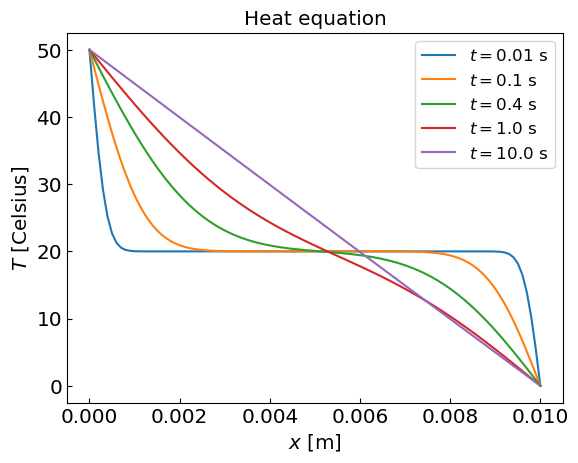

CPU times: user 7.79 s, sys: 255 ms, total: 8.04 s
Wall time: 8.9 s


In [7]:
%%time

# 定数
L = 0.01 # 棒の長さ（メートル）
D = 4.25e-6 # 熱拡散率
N = 100 # グリッドの分割数
a = L/N # グリッド間隔
h = 1e-4 # 時間ステップ（秒）
print("Solving the heat equation with FTCS scheme")
print("r = h*D/a^2 =",h*D/a**2)

Tlo  = 0.0     # 低温側（摂氏温度）
Tmid = 20.0    # 初期温度（摂氏温度）
Thi  = 50.0    # 高温側（摂氏温度）

# 初期化
u = np.zeros([N+1],float)
# 初期温度
u[1:N] = Tmid
# 境界値
u[0] = Thi
u[N] = Tlo

# 出力のために準備：
times    = [ 0.01, 0.1, 0.4, 1.0, 10.0 ]
profiles = []
xk       = [k*a for k in range(0,N+1)]

current_time = 0.
for time in times:
    nsteps = round((time - current_time)/h)
    u = heat_FTCS_solve(u, h, nsteps, a, D)
    profiles.append(u.copy())
    current_time = time
    
plt.title("Heat equation")
plt.xlabel('${x}$ [m]')
plt.ylabel('${T}$ [Celsius]')
for i in range(len(times)):
    plt.plot(xk,profiles[i],label="${t=}$" + str(times[i]) + " s")
plt.legend()
plt.show()

ここで、$r > 1/2$ となるような大きい時間刻み幅を試す。

Solving the heat equation with FTCS scheme
r = h*D/a^2 = 0.5099999999999999


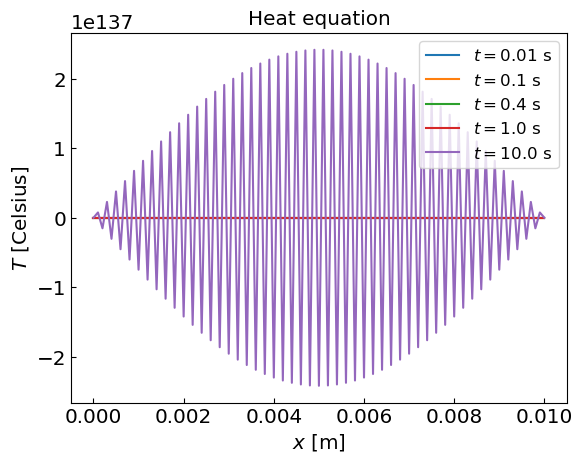

CPU times: user 887 ms, sys: 90 ms, total: 977 ms
Wall time: 778 ms


In [8]:
%%time

# Constants
L = 0.01 # 棒の長さ（メートル）
D = 4.25e-6 # 熱拡散率
N = 100 # グリッドの分割数
a = L/N # グリッド間隔
h = 1.2e-3 # 時間ステップ（秒）

print("Solving the heat equation with FTCS scheme")
print("r = h*D/a^2 =",h*D/a**2)

Tlo  = 0.0     # 低温側（摂氏温度）
Tmid = 20.0    # 初期温度（摂氏温度）
Thi  = 50.0    # 高温側（摂氏温度）

# 初期化
u = np.zeros([N+1],float)
# 初期温度
u[1:N] = Tmid
# 境界値
u[0] = Thi
u[N] = Tlo

# 出力のために準備：
times    = [ 0.01, 0.1, 0.4, 1.0, 10.0 ]
profiles = []
xk       = [k*a for k in range(0,N+1)]

current_time = 0.
for time in times:
    nsteps = round((time - current_time)/h)
    u = heat_FTCS_solve(u, h, nsteps, a, D)
    profiles.append(u.copy())
    current_time = time
    
plt.title("Heat equation")
plt.xlabel('${x}$ [m]')
plt.ylabel('${T}$ [Celsius]')
for i in range(len(times)):
    plt.plot(xk,profiles[i],label="${t=}$" + str(times[i]) + " s")
plt.legend()
plt.show()

$r<1/2$ となるように、空間のステップサイズを変えたらどうなるか？

Solving the heat equation with FTCS scheme
r = h*D/a^2 = 0.41309999999999986


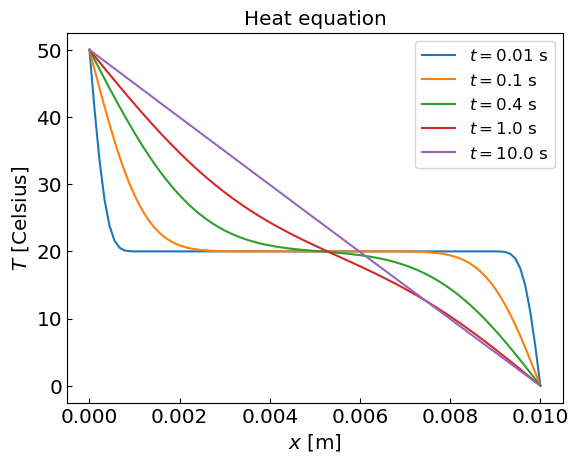

CPU times: user 863 ms, sys: 90.4 ms, total: 954 ms
Wall time: 752 ms


In [9]:
%%time

L = 0.01 # 棒の長さ（メートル）
D = 4.25e-6 # 熱拡散率
N = 90 # グリッドの分割数
a = L/N # グリッド間隔
h = 1.2e-3 # 時間ステップ（秒）

print("Solving the heat equation with FTCS scheme")
print("r = h*D/a^2 =",h*D/a**2)

Tlo  = 0.0     # 低温側（摂氏温度）
Tmid = 20.0    # 初期温度（摂氏温度）
Thi  = 50.0    # 高温側（摂氏温度）

# 初期化
u = np.zeros([N+1],float)
# 初期温度
u[1:N] = Tmid
# 境界値
u[0] = Thi
u[N] = Tlo

# 出力のために準備：
times    = [ 0.01, 0.1, 0.4, 1.0, 10.0 ]
profiles = []
xk       = [k*a for k in range(0,N+1)]

current_time = 0.
for time in times:
    nsteps = round((time - current_time)/h)
    u = heat_FTCS_solve(u, h, nsteps, a, D)
    profiles.append(u.copy())
    current_time = time
    
plt.title("Heat equation")
plt.xlabel('${x}$ [m]')
plt.ylabel('${T}$ [Celsius]')
for i in range(len(times)):
    plt.plot(xk,profiles[i],label="${t=}$" + str(times[i]) + " s")
plt.legend()
plt.show()

## 2. 陰解法

陰解法では、時間微分に後方差分を使用する。
これは、
$$
\frac{\partial u(t+h,x)}{\partial t} \approx \frac{u(t+h,x) - u(t,x)}{h}\,,
$$
したがって、
$$
\frac{u(t+h,x) - u(t,x)}{h} = D \frac{u(t+h,x+a) - 2u(t+h,x) + u(t+h,x-a)}{a^2}\,.
$$
離散化した記法では
$$
u^{n+1}_k = u^n_k + r \, (u^{n+1}_{k+1} - 2u^{n+1}_k + u^{n+1}_{k-1}), \qquad k = 1 \ldots N-1.
$$
言い換えれば、$u^{n+1}_i$ について線形方程式系が成り立つ。
$$
-r u^{n+1}_{k-1} + (1+2r) u^{n+1}_{k} - r u^{n+1}_{k+1} = u^n_k, \qquad k = 1 \ldots N-1.
$$
この方程式を各時間ステップ $n+1$ で解く必要があります。幸いにして、この系は三重対角行列なので、線形時間で解けます。
三重対角行列を解くのには、scipy.linalg の solve_banded を使う。

In [10]:
import numpy as np
from scipy.linalg import solve_banded

# 三重対角線線形方程式を解く
# d: 対角要素のベクトル
# l: 下側下対角要素のベクトル
# u: 上側上対角要素のベクトル
# v0: 右辺ベクトル
def linsolve_tridiagonal(d, l, u, v0):
    
    ab = np.array([u, d, l])
    x = solve_banded((1,1), ab, v0)

    return x

In [11]:


# 時間方向のFTCSスキームの単一反復
# 新しいフィールドはunewに書き込まれる
# r = Dh/a^2は無次元パラメータである
def heat_implicit_iteration(u, r):
    N = len(u) - 1
    
    unew = np.empty_like(u)
    
    # 境界条件
    unew[0] = u[0]
    unew[N] = u[N]
    
    d  = np.full(N-1, 1+2.*r)
    ud = np.full(N-1, -r)
    ld = np.full(N-1, -r)
    v  = np.array(u[1:N])
    v[0]   += r * u[0]
    v[N-2] += r * u[N]
    
    unew[1:N] = linsolve_tridiagonal(d,ld,ud,v)
    
    return unew


# 熱方程式のFTCS時間反復計算を実行
# u0: 初期分布
# h: 時間ステップのサイズ
# nsteps: 時間ステップ数
# a: 空間セルサイズ
# D: 拡散定数
def heat_implicit_solve(u0, h, nsteps, a, D = 1.):
    u = u0.copy()
    r = h * D / a**2
    # print("Heat equation with r =", r)
    for i in range(nsteps):
        u = heat_implicit_iteration(u, r)
        
    return u

Solving the heat equation with implicit scheme
r = h*D/a^2 = 4.25


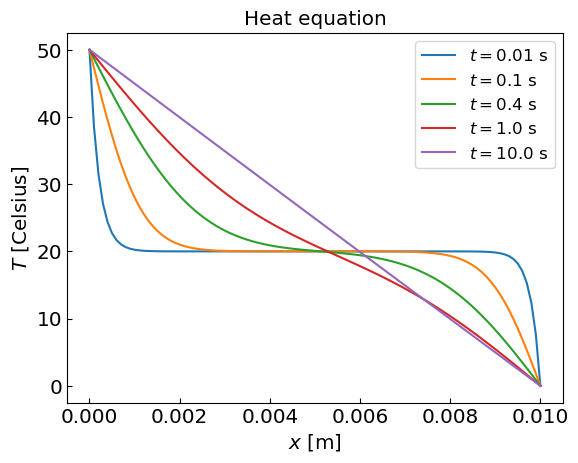

CPU times: user 370 ms, sys: 81.1 ms, total: 451 ms
Wall time: 242 ms


In [12]:
%%time

# 定数
L = 0.01 # 棒の長さ（メートル）
D = 4.25e-6 # 熱拡散率
N = 100 # グリッドの分割数
a = L/N # グリッド間隔
h = 1e-2 # 時間ステップ（秒）

print("Solving the heat equation with implicit scheme")
print("r = h*D/a^2 =",h*D/a**2)

Tlo  = 0.0     # 低温側（摂氏温度）
Tmid = 20.0    # 初期温度（摂氏温度）
Thi  = 50.0    # 高温側（摂氏温度）

# 初期化
u = np.zeros([N+1],float)
# 初期温度
u[1:N] = Tmid
# 境界値
u[0] = Thi
u[N] = Tlo

# 出力のために準備：
times    = [ 0.01, 0.1, 0.4, 1.0, 10.0 ]
profiles = []
xk       = [k*a for k in range(0,N+1)]

current_time = 0.
for time in times:
    nsteps = round((time - current_time)/h)
    u = heat_implicit_solve(u, h, nsteps, a, D)
    # u = heat_FTCS_solve(u, h, nsteps, a, D)
    profiles.append(u.copy())
    current_time = time
    
plt.title("Heat equation")
plt.xlabel('${x}$ [m]')
plt.ylabel('${T}$ [Celsius]')
for i in range(len(times)):
    plt.plot(xk,profiles[i],label="${t=}$" + str(times[i]) + " s")
plt.legend()
plt.show()

アニメーション

MovieWriter ffmpeg unavailable; using Pillow instead.


Solving the heat equation with FTCS scheme
r = h*D/a^2 = 0.425
CPU times: user 13.2 s, sys: 655 ms, total: 13.9 s
Wall time: 14.1 s


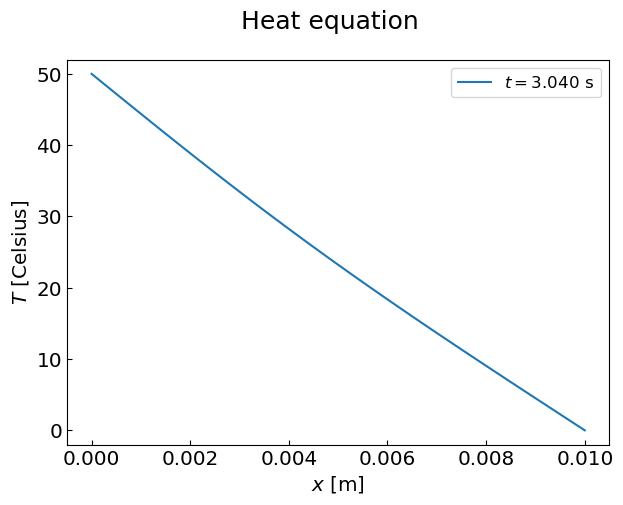

In [13]:
%%time

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# 定数
L = 0.01 # 棒の長さ（メートル）
D = 4.25e-6 # 熱拡散率
N = 100 # グリッドの分割数
a = L/N # グリッド間隔
h = 1e-3 # 時間ステップ（秒）

# print("Solving the heat equation with implicit scheme")
print("Solving the heat equation with FTCS scheme")
print("r = h*D/a^2 =",h*D/a**2)

Tlo  = 0.0     # 低温側（摂氏温度）
Tmid = 20.0    # 初期温度（摂氏温度）
Thi  = 50.0    # 高温側（摂氏温度）

# 初期化
u = np.zeros([N+1],float)
# 初期温度
u[1:N] = Tmid
# 境界値
u[0] = Thi
u[N] = Tlo

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(7, 5, forward=True)
fig.suptitle("Heat equation", fontsize = 18)
current_time = 0
def animate_heat_equation_1D(i):
    ax.clear()
    global fps
    niters = round((0.1/fps)/h)
    global u, current_time
    u = heat_implicit_solve(u, h, niters, a, D)
    # u = heat_FTCS_solve(u, h, niters, a, D)
    current_time += h * niters
    
    plt.xlabel('${x}$ [m]')
    plt.ylabel('${T}$ [Celsius]')
    plt.plot(xk,u,label="${t=}$" + "{:.3f}".format(current_time) + " s")
    plt.legend(loc="upper right")
    plt.ylim(-2,52)
    # plt.show()

fps = 5
tend = 3.
ani = FuncAnimation(fig, animate_heat_equation_1D, frames=fps * round(tend) * 10, interval=200/fps, repeat=True)

ani.save("heat_equation_1D_implicit.gif")
# ani.save("heat_equation_1D_FTCS.gif")

# HTML(ani.to_jshtml())

## 3. Crank-Nicolson 法

クランク・ニコルソン法は、FTCS法と陰解法を組み合わせたもの。
本質的には、時間微分を陽解法と陰解法の平均として近似することに相当する。
$$
\frac{\partial u(t,x)}{\partial t} \approx \frac{1}{2} \left[ D \, \frac{\partial^2 u(t+h,x)}{\partial x^2} + D \, \frac{\partial^2 u(t,x)}{\partial x^2} \right].
$$

空間微分に中心差分を適用すると、次の式が得られる。
$$
\frac{u(t+h,x) - u(t,x)}{h} = \frac{D}{2} \frac{u(t+h,x+a) - 2u(t+h,x) + u(t+h,x-a)}{a^2} + \frac{D}{2} \frac{u(t,x+a) - 2u(t,x) + u(t,x-a)}{a^2}.
$$

これは次の三重対角線線形方程式系に対応する。
$$
-r u^{n+1}_{k-1} + 2(1+r) u^{n+1}_{k} - r u^{n+1}_{k+1} = ru^n_{k-1} + 2(1-r)u^n_k + ru^n_{k+1}, \qquad k = 1 \ldots N-1.
$$

In [14]:
import numpy as np

def heat_crank_nicolson_iteration(u, r):
    N = len(u) - 1
    
    unew = np.empty_like(u)
    
    # 境界条件
    unew[0] = u[0]
    unew[N] = u[N]
    
    d  = np.full(N-1, 2*(1+r))
    ud = np.full(N-1, -r)
    ld = np.full(N-1, -r)
    
    # Crank-Nicolson の1ステップ
    v = u[1:N]*2*(1-r) + u[:-2]*r + u[2:]*r
    v[0]   += r * u[0]
    v[N-2] += r * u[N]
    
    unew[1:N] = linsolve_tridiagonal(d, ld, ud, v)
    
    return unew

def heat_crank_nicolson_solve(u0, h, nsteps, a, D = 1.):
    u = u0.copy()
    r = h * D / (a**2)
    for i in range(nsteps):
        u = heat_crank_nicolson_iteration(u, r)
        
    return u

Solving the heat equation with Crank-Nicolson scheme
r = h*D/a^2 = 4.25


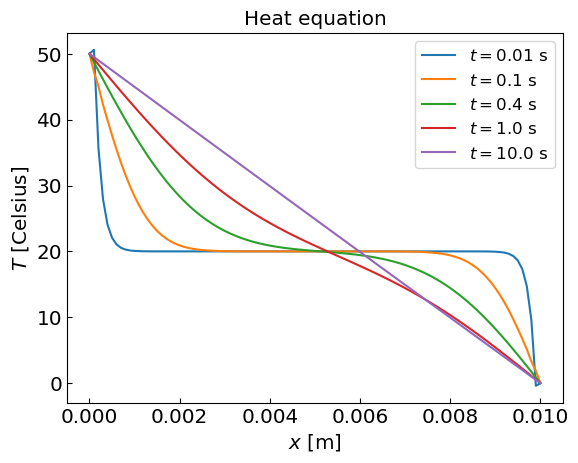

CPU times: user 385 ms, sys: 82.3 ms, total: 467 ms
Wall time: 283 ms


In [15]:
%%time

# 定数
L = 0.01 # 棒の長さ（メートル）
D = 4.25e-6 # 熱拡散率
N = 100 # グリッドの分割数
a = L/N # グリッド間隔
h = 1e-2 # 時間ステップ（秒）

print("Solving the heat equation with Crank-Nicolson scheme")
print("r = h*D/a^2 =",h*D/a**2)

Tlo  = 0.0     # 低温側（摂氏温度）
Tmid = 20.0    # 初期温度（摂氏温度）
Thi  = 50.0    # 高温側（摂氏温度）

# 初期化
u = np.zeros([N+1],float)
# 初期温度
u[1:N] = Tmid
# 境界値
u[0] = Thi
u[N] = Tlo

# 出力のために準備：
times    = [ 0.01, 0.1, 0.4, 1.0, 10.0 ]
profiles = []
xk       = [k*a for k in range(0,N+1)]

current_time = 0.
for time in times:
    nsteps = round((time - current_time)/h)
    u = heat_crank_nicolson_solve(u, h, nsteps, a, D)
    profiles.append(u.copy())
    current_time = time
    
plt.title("Heat equation")
plt.xlabel('${x}$ [m]')
plt.ylabel('${T}$ [Celsius]')
for i in range(len(times)):
    plt.plot(xk,profiles[i],label="${t=}$" + str(times[i]) + " s")
plt.legend()
plt.show()

# 実習: 波動方程式

波動方程式は、波動と定在波場を記述する2階線形偏微分方程式の一例である。1次元では、次のように記述される。
$$
\frac{\partial^2 \phi}{\partial t^2} = v^2 \frac{\partial^2 \phi}{\partial x^2}.
$$

これは2階偏微分方程式であるため、$\phi(t=0,x)$ と $\phi_t'(t=0,x)$ の両方の初期条件が補足される。
\begin{align*}
\phi(t=0,x) & = \phi_0(x) ,\\
\phi_t'(t=0,x) & = \phi'_0(x).
\end{align*}

境界条件は、ディリクレ形式
\begin{align*}
\phi(t,x=0) & = \phi_{\rm left}(t) ,\\
\phi(t,x=L) & = \phi_{\rm right}(t),
\end{align*}
またはノイマン形式
\begin{align*}
\phi'_x(t,x=0) & = \phi'_{\rm left}(t) ,\\
\phi'_x(t,x=L) & = \phi'_{\rm right}(t),
\end{align*}
のいずれかとなる。

ここではディリクレ形式を考える。

## 有限差分アプローチ

2階の時間微分を扱うために、次のように表記する。
$$
\psi(t,x) \equiv \frac{\partial \phi}{\partial t}
$$
このようにして、1階（$t$ 方向）偏微分方程式系を扱う。
\begin{align*}
\frac{\partial \phi}{\partial t} = \psi(t,x), \\
\frac{\partial \psi}{\partial t} = v^2 \frac{\partial^2 \phi}{\partial x^2}.
\end{align*}

差分法を適用するには、まず、熱方程式の場合と同様に、導関数 $\partial^2 \phi / \partial x^2$ を最低階の中心差分で近似する。
$$
\frac{\partial^2 \phi(t,x)}{\partial x^2} \approx \frac{\phi(t,x+a) - 2\phi(t,x) + \phi(t,x-a)}{a^2}.
$$

偏微分方程式を数値的に解くには、熱方程式の場合と同じ手順を、$\phi(t,x)$ と $\psi(t,x)$ を同時に適用する。
$\phi(t = nh,x = ka) = \phi^n_k$ および $\psi(t = nh,x = ka) = \psi^n_k$ と書くと、次の式が得られる。

### FTCS 法
$$
\begin{align*}
\phi^{n+1}_k & = \phi^{n}_k + h \psi^n_k, \\
\psi^{n+1}_k & = \psi^n_k + r \, (\phi^n_{k+1} - 2\phi^n_k + \phi^n_{k-1}), \qquad k = 1 \ldots N-1.
\end{align*}
$$
### 陰解法
$$
\begin{align}
\phi^{n+1}_k & = \phi^{n}_k + h \psi^{n+1}_k, \\
\psi^{n+1}_k & = \psi^n_k + r \, (\phi^{n+1}_{k+1} - 2\phi^{n+1}_k + \phi^{n+1}_{k-1}), \qquad k = 1 \ldots N-1.
\end{align}
$$

### Crank-Nicolson 法
$$
\begin{align}
\phi^{n+1}_k & = \phi^{n}_k + \frac{h}{2} \left[ \psi^{n+1}_k + \psi^{n}_k\right], \\
\psi^{n+1}_k & = \psi^n_k + \frac{r}{2} \, (\phi^{n+1}_{k+1} - 2\phi^{n+1}_k + \phi^{n+1}_{k-1}) + \frac{r}{2} \, (\phi^{n}_{k+1} - 2\phi^{n}_k + \phi^{n}_{k-1}), \qquad k = 1 \ldots N-1.
\end{align}
$$

ここでは、Crank-Nicolson法で解くことを考えよう。

第1式を第2式に代入すると、$\psi^{n+1}_k$の三角対角な線形方程式系が得られる：
$$
-rh \psi^{n+1}_{k+1} + 2(1+rh) \psi^{n+1}_k - rh \psi^{n+1}_{k-1} = 2 \psi^n_k + 2r \, (\phi^{n}_{k+1} - 2\phi^{n}_k + \phi^{n}_{k-1}) + rh \, (\psi^{n}_{k+1} - 2\psi^{n}_k + \psi^{n}_{k-1}), \quad k = 1\ldots N-1.
$$

これを、上での熱伝導方程式の場合を参考にして、解いてみよ。
プロットする際には例として t= 1., 5., 10., 20., 190., 290. で見積もってみよ。